# Task-3

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Load Datasets

In [2]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

## Build a Model for Clustering

In [3]:
def prepare_customer_features():
    # Aggregate Transaction feature
    transaction_features = transactions.groupby('CustomerID').agg({
            'TotalValue' : ['sum','mean', 'count'],
            'Quantity' : ['sum', 'mean']
    }).reset_index()
    
    # Flatten Column names
    transaction_features.columns = [
        'CustomerID', 'TotalSpend', 'AvgTransactionValue', 'TransactionCount',
        'TotalQuantity', 'AvgQuantity'
    ]
    
    # Merge with customer demographic data
    customer_data = customers.merge(transaction_features, on = "CustomerID")
    
    return customer_data

In [4]:
# Preprocessing
def create_preprocessor():
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', StandardScaler(), [
                'TotalSpend', 'AvgTransactionValue', 'TransactionCount',
                'TotalQuantity', 'AvgQuantity']
            ),
            ('cat', OneHotEncoder(handle_unknown = "ignore"), ['Region'])
        ]
    )
    
    return preprocessor

In [5]:
# Manual KMeans Implementation to avoid threading issues

def manual_kmeans(X, n_clusters, max_iter = 100):
    # Randomly initialize centroids
    np.random.seed(42)
    centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    
    for _ in range(max_iter):
        # Assign points to nearest centroid
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        
        # Update centroids
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return labels, centroids

In [6]:
# Clustering with DB Index Optimization
def perform_clustering(X_transformed):
    db_scores = []
    silhouette_scores = []
    
    # Try different cluster numbers
    for n_clusters in range(2, 11):
        # Use manual Kmeans implementation
        clusters, _ = manual_kmeans(X_transformed, n_clusters)
        
        # Calculate metrics
        db_score = davies_bouldin_score(X_transformed, clusters)
        silhouette = silhouette_score(X_transformed, clusters)
        
        db_scores.append(db_score)
        silhouette_scores.append(silhouette)
    
    # Find optimal clusters (lowest DB Index)
    optimal_clusters = db_scores.index(min(db_scores)) + 2
    
    return optimal_clusters, db_scores, silhouette_scores

In [7]:
def visualize_clusters(X_transformed, clusters):
    plt.figure(figsize=(12, 5))
    
    # Dimensionality reduction for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_transformed)
    
    # Scatter Plot with color map
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.title('Customer Clusters', fontsize=14)
    plt.xlabel('First Principal Component', fontsize=12)
    plt.ylabel('Second Principal Component', fontsize=12)
    
    # Add color bar
    plt.colorbar(scatter, label='Cluster')
    
    plt.tight_layout()
    plt.savefig('customer_clusters.png')
    plt.show()


In [8]:
def customer_segmentation():
    # Prepare features
    customer_data = prepare_customer_features()
    
    # Preprocessing
    preprocessor = create_preprocessor()
    
    # Prepare feature matrix
    X = customer_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)
    X_transformed = preprocessor.fit_transform(X)
    
    # Clustering
    optimal_clusters, db_scores, silhouette_scores = perform_clustering(X_transformed)
    
    # Final clustering with optimal clusters
    final_clusters, _ = manual_kmeans(X_transformed, optimal_clusters)
    
    # Visualize
    visualize_clusters(X_transformed, final_clusters)
    
    # Prepare results in a cleaner format
    cluster_sizes = [sum(final_clusters == i) for i in range(optimal_clusters)]
    silhouette_score_per_cluster = [silhouette_scores[i] if i < len(silhouette_scores) else None for i in range(optimal_clusters)]
    
    cluster_summary = pd.DataFrame({
        'Cluster': range(optimal_clusters),
        'Size': cluster_sizes,
        'Silhouette Score': silhouette_score_per_cluster
    })
    
    result = {
        'OptimalClusters': optimal_clusters,
        'DBScores': db_scores,
        'SilhouetteScores': silhouette_scores,
        'ClusterSummary': cluster_summary
    }
    
    return result




## Results

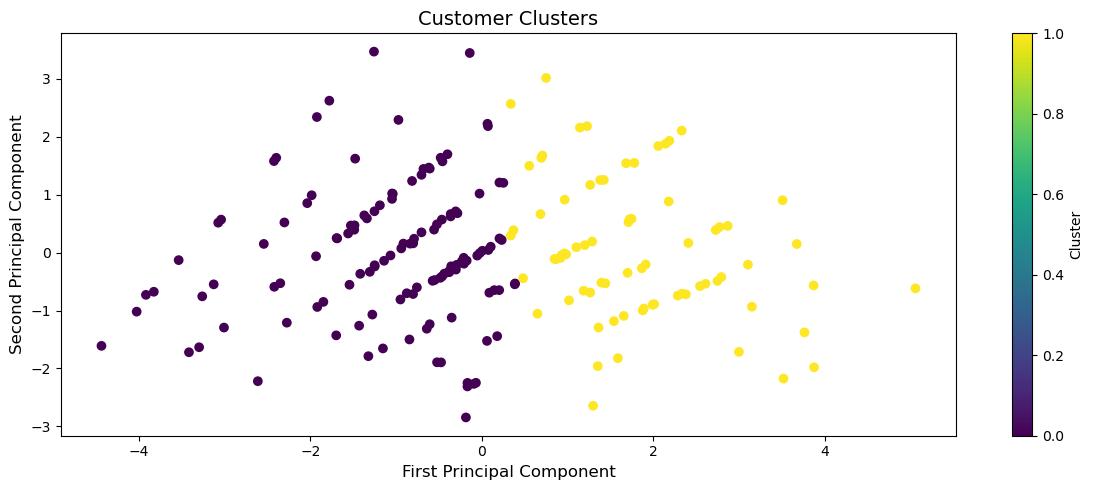

Clustering Results:
Optimal number of clusters: 2

DB Scores:
 [1.2436768550642197, 1.4660521728929117, 1.3407013102268885, 1.4056784783406377, 1.5062414887513664, 1.6022005957185097, 1.5428752364643108, 1.5906232530656985, 1.5641730205552749]

Silhouette Scores:
 [0.29860922038515253, 0.22616823937863492, 0.22442834968203587, 0.19405352433412076, 0.18992339630284452, 0.15726682364596964, 0.16788084811206275, 0.16568459803233704, 0.16864775865431672]

Cluster Summary:
   Cluster  Size  Silhouette Score
0        0   125          0.298609
1        1    74          0.226168


In [9]:
# Run the analysis
results = customer_segmentation()

# Display results
print("Clustering Results:")
print(f"Optimal number of clusters: {results['OptimalClusters']}")
print("\nDB Scores:\n", results['DBScores'])
print("\nSilhouette Scores:\n", results['SilhouetteScores'])
print("\nCluster Summary:")
print(results['ClusterSummary'])